<a href="https://colab.research.google.com/github/dainisws/bakalaura_darbam/blob/main/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

In [4]:
# Datu ielāde no 8 failiem
data1 = pd.read_csv('/content/drive/MyDrive/MachineLearningCSV/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv')
data2 = pd.read_csv('/content/drive/MyDrive/MachineLearningCSV/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv')
data3 = pd.read_csv('/content/drive/MyDrive/MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv')
data4 = pd.read_csv('/content/drive/MyDrive/MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
data5 = pd.read_csv('/content/drive/MyDrive/MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
data6 = pd.read_csv('/content/drive/MyDrive/MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv')
data7 = pd.read_csv('/content/drive/MyDrive/MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
data8 = pd.read_csv('/content/drive/MyDrive/MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

In [5]:
data_list = [data1, data2, data3, data4, data5, data6, data7, data8]
data_combined = pd.concat(data_list)

# Izvada datu dimensijas
rows, cols = data_combined.shape
print('New dimension:')
print(f'Number of rows: {rows}, Number of columns: {cols}')
print(f'Total cells: {rows * cols}')

# Deleting dataframes after concating to save memory
for d in data_list: del d

# Noņem liekās atstarpes no kolonnu nosaukumiem
col_names = {col: col.strip() for col in data_combined.columns}
data_combined.rename(columns = col_names, inplace = True)

data_combined.columns


New dimension:
Number of rows: 2830743, Number of columns: 79
Total cells: 223628697


Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [6]:
data_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  Flow I

In [7]:
# Daru tīrīšana
# Dublētu vērtību identificēšana
dups = data_combined[data_combined.duplicated()]
print(f'Number of duplicates: {len(dups)}')

Number of duplicates: 308381


In [8]:
# Noņemam visus dubultos ierakstus
data_combined.drop_duplicates(inplace = True)
data_combined.shape

(2522362, 79)

In [9]:
# Trūkstošo vērtību noteikšana
missing_val = data_combined.isna().sum()
print(missing_val.loc[missing_val > 0])

Flow Bytes/s    353
dtype: int64


In [10]:
# Bezgalības vērtību pārbaude
numeric_cols = data_combined.select_dtypes(include = np.number).columns
inf_count = np.isinf(data_combined[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


In [11]:
# Jebkuru bezgalīgu vērtību (pozitīvu vai negatīvu) aizstāšana ar NaN (nevis skaitli)
print(f'Initial missing values: {data_combined.isna().sum().sum()}')

data_combined.replace([np.inf, -np.inf], np.nan, inplace = True)

print(f'Missing values after processing infinite values: {data_combined.isna().sum().sum()}')

Initial missing values: 353
Missing values after processing infinite values: 3128


In [12]:
# Identificējam un saskaitītām trūkstošās vērtības
missing = data_combined.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s      1564
Flow Packets/s    1564
dtype: int64


In [13]:
# Trūkstošo vērtību procentuālās daļas aprēķināšana
mis_per = (missing / len(data_combined)) * 100
print(mis_per[mis_per > 0].round(2))

Flow Bytes/s      0.06
Flow Packets/s    0.06
dtype: float64


In [14]:
# Mediānas noteikšana
med_flow_bytes = data_combined['Flow Bytes/s'].median()
med_flow_packets = data_combined['Flow Packets/s'].median()

# Trūkstošo vērtību aizpildīšana ar mediānu
data_combined['Flow Bytes/s'] = data_combined['Flow Bytes/s'].fillna(med_flow_bytes)
data_combined['Flow Packets/s'] = data_combined['Flow Packets/s'].fillna(med_flow_packets)

print('Number of \'Flow Bytes/s\' missing values:', data_combined['Flow Bytes/s'].isna().sum())
print('Number of \'Flow Packets/s\' missing values:', data_combined['Flow Packets/s'].isna().sum())

Number of 'Flow Bytes/s' missing values: 0
Number of 'Flow Packets/s' missing values: 0


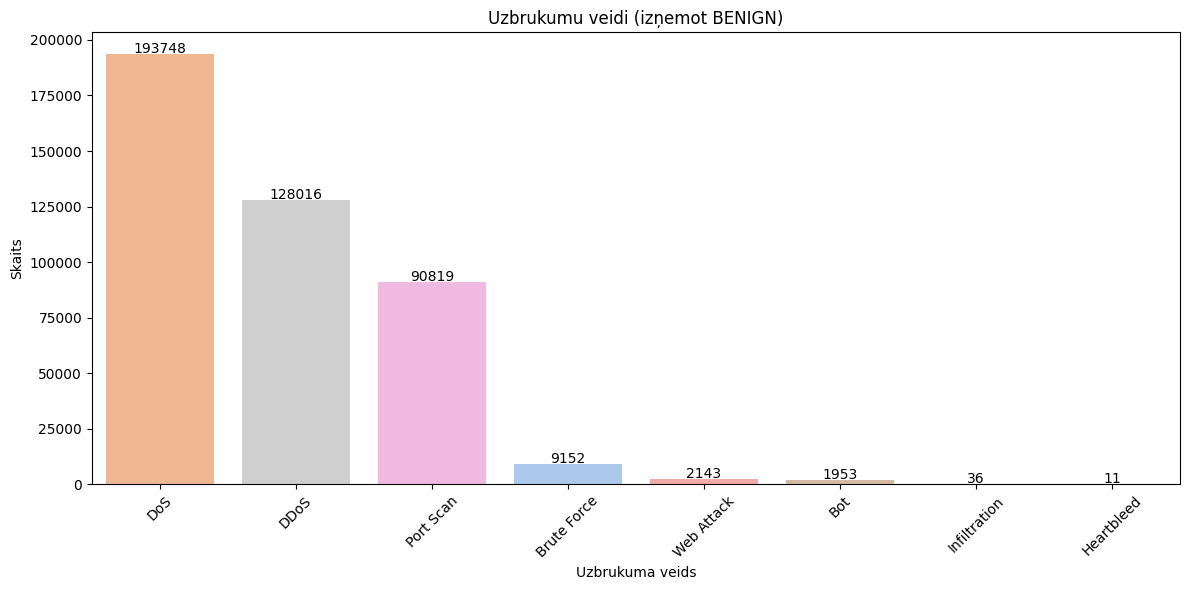

In [15]:
# Creating a dictionary that maps each label to its attack type
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Ja "Attack Type" kolonna nav, izmanto "Label" tās vietā
data_combined['Attack Type'] = data_combined['Label'].map(attack_map)

import matplotlib.pyplot as plt
import seaborn as sns

# Izfiltrē visus izņemot "BENIGN"
attacks = data_combined.loc[data_combined['Attack Type'] != 'BENIGN']

plt.figure(figsize=(12, 6))
ax = sns.countplot(
    x='Attack Type',
    hue='Attack Type',
    data=attacks,
    palette='pastel',
    order=attacks['Attack Type'].value_counts().index,
    legend=False
)
plt.title('Uzbrukumu veidi (izņemot BENIGN)')
plt.xlabel('Uzbrukuma veids')
plt.ylabel('Skaits')
plt.xticks(rotation=45)

# Skaitliskie anotācijas virs stabiņiem
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height() + 500), ha='center')

plt.tight_layout()
plt.show()


In [17]:
# Atdala iezīmes (X) un mērķa mainīgo (y)

X = data_combined.drop(['Label', 'Attack Type'], axis=1)
y = data_combined['Label']

# Konvertē mērķa mainīgo (Label) uz skaitlisko vērtību ar LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Sadala datus treniņu un testēšanas kopās
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=0)

# Standartizē datu iezīmes
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [19]:
# Apmāca Decision Tree modeli
dt = DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)

# 5-fold cross-validation
cv_dt = cross_val_score(dt, X_train, y_train, cv=3)

# Izvada rezultātus
print('📊 Decision Tree Model (Cross-Validation pieeja)')
print(f'\nCross-validation scores: {", ".join(map(lambda x: f"{x:.2f}", cv_dt))}')
print(f'Mean cross-validation score: {cv_dt.mean():.2f}')

📊 Decision Tree Model (Cross-Validation pieeja)

Cross-validation scores: 0.99, 0.99, 0.99
Mean cross-validation score: 0.99
